In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import matplotlib.image as mpimg
import numpy as np
import glob

# Exploratory Data Analysis

## Analyzing Data Distribution

In [3]:
image_list = []
base_dir = 'trafficsigns_dataset'

# Loop through each directory and append only images to image_list
for filepath in glob.glob(os.path.join(base_dir, '*', '*', '*.png')):
    filename = os.path.basename(filepath)
    sign_type = os.path.basename(os.path.dirname(filepath))
    sign_shape = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
    image_path = os.path.join(sign_shape, sign_type)

    img = Image.open(filepath)  

    image_list.append((filepath, image_path, filename, sign_shape, sign_type, f"{img.width}x{img.height}"))
    img.close()
    
# create dataframe
data = pd.DataFrame(data=image_list, columns=['filepath', 'image_path', 'filename' ,'sign_shape' ,'sign_type', 'dimension'])

In [4]:
# assign shapes to a numeric categorical value
shapes = {'diamond':0, 'hex':1, 'round':2, 'square':3, 'triangle':4}

# assign sign types to a numeric categorical value
types = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection':9, 'continue':10, 'crossing':11 , 'laneend':12, 'parking':13, 'giveway':14, 'warning':15}

# map shape and type category numbers to dataframe
data['sign_shape_num'] = data['sign_shape'].map(shapes)
data['sign_type_num'] = data['sign_type'].map(types)

data.head(10)

,filepath,image_path,filename,sign_shape,sign_type,dimension,sign_shape_num,sign_type_num
0,trafficsigns_dataset/diamond/rightofway/00039_...,diamond/rightofway,00039_00001.png,diamond,rightofway,28x28,0,0
1,trafficsigns_dataset/diamond/rightofway/01803_...,diamond/rightofway,01803_00002.png,diamond,rightofway,28x28,0,0
2,trafficsigns_dataset/diamond/rightofway/01702_...,diamond/rightofway,01702_00000.png,diamond,rightofway,28x28,0,0
3,trafficsigns_dataset/diamond/rightofway/00111_...,diamond/rightofway,00111_00001.png,diamond,rightofway,28x28,0,0
4,trafficsigns_dataset/diamond/rightofway/01231_...,diamond/rightofway,01231_00003.png,diamond,rightofway,28x28,0,0
5,trafficsigns_dataset/diamond/rightofway/00957_...,diamond/rightofway,00957_00002.png,diamond,rightofway,28x28,0,0
6,trafficsigns_dataset/diamond/rightofway/01231_...,diamond/rightofway,01231_00002.png,diamond,rightofway,28x28,0,0
7,trafficsigns_dataset/diamond/rightofway/00111_...,diamond/rightofway,00111_00000.png,diamond,rightofway,28x28,0,0
8,trafficsigns_dataset/diamond/rightofway/01702_...,diamond/rightofway,01702_00001.png,diamond,rightofway,28x28,0,0
9,trafficsigns_dataset/diamond/rightofway/01013_...,diamond/rightofway,01013_00002.png,diamond,rightofway,28x28,0,0


In [5]:
# Output the result.
print("Following are the count of the number of images in each shape: \n")
data['image_path'].value_counts()

Following are the count of the number of images in each shape: 



image_path
triangle/warning          695
round/noentry             375
round/speed               316
round/bicycle             285
diamond/rightofway        282
square/parking            276
round/noparking           242
triangle/giveway          231
square/continue           199
round/trafficdirective    195
round/limitedtraffic      125
round/traveldirection     124
square/laneend            118
round/roundabout           98
square/crossing            95
hex/stop                   43
Name: count, dtype: int64

### Now I will analyze the number of images in each sub-directory i.e. image type in each shape using histogram

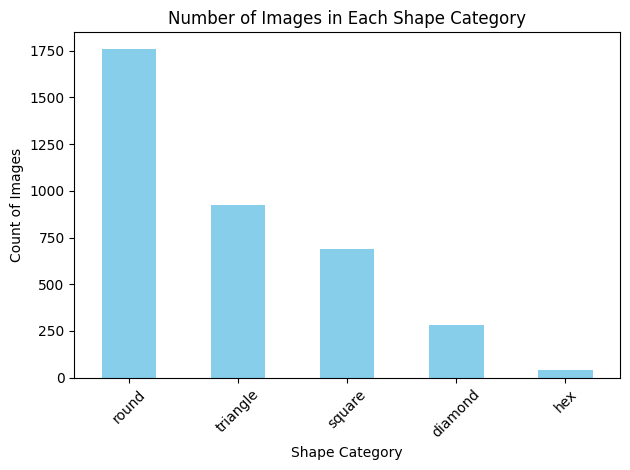

In [6]:
# plot histogram of sign shapes
data['sign_shape'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images in Each Shape Category')
plt.xlabel('Shape Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()


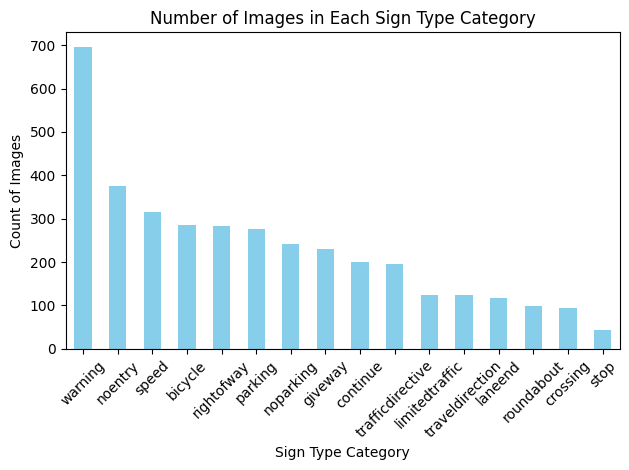

In [7]:
# plot histogram of sign shapes
data['sign_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images in Each Sign Type Category')
plt.xlabel('Sign Type Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()


## Analyzing Size Distribution

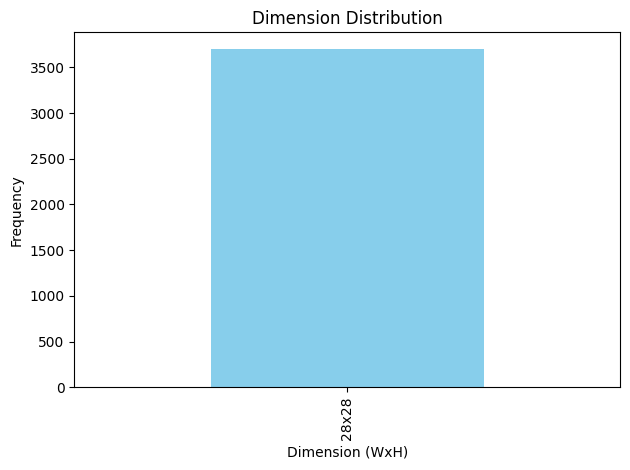

In [8]:
# Plotting
data['dimension'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Dimension Distribution')
plt.xlabel('Dimension (WxH)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Color Analysis

The following code computes and visualizes the average distribution of pixel intensities for the Red, Green, and Blue channels across all images in a specified dataset. It does this by:

1. Initializing storage to accumulate color data and track the number of images.
2. Iterating through the dataset's directory structure, processing each image to extract its color histograms.
3. Averaging these histograms by channel to get a sense of the typical color profile across the dataset.
4. Plotting the averaged histograms for visual analysis, presenting the commonality of pixel intensities in each color channel across the dataset.
The resulting visualizations provide insights into the dominant colors and brightness levels within the traffic sign images, which is valuable for understanding the data's characteristics and preparing for machine learning tasks.

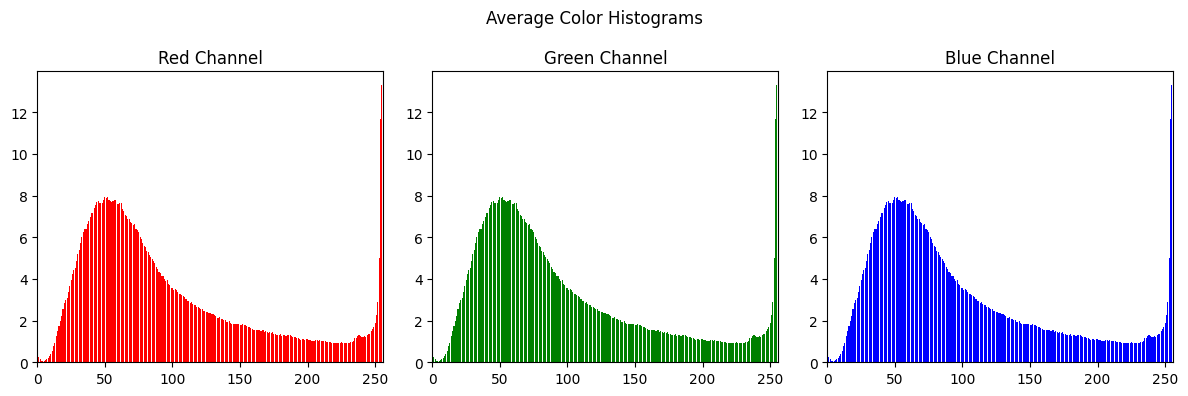

In [9]:

color_sums = [np.zeros(256), np.zeros(256), np.zeros(256)]  # For RGB channels
num_images = 0

# Loop through each subdirectory and compute color histograms
for image in image_list:
    file_path = image[0]
    with Image.open(file_path) as img:
        img = img.convert('RGB')  # Ensure image is in RGB
        for i in range(3):  # RGB channels
            hist, _ = np.histogram(img.getdata(band=i), bins=256, range=(0, 256))
            color_sums[i] += hist
        num_images += 1

# Calculate the average histograms
avg_histograms = [sums / num_images for sums in color_sums]

# Plot the average histograms
plt.figure(figsize=(12, 4))
colors = ['Red', 'Green', 'Blue']
for i, color in enumerate(colors):
    plt.subplot(1, 3, i + 1)
    plt.bar(range(256), avg_histograms[i], color=color.lower())
    plt.title(f'{color} Channel')
    plt.xlim([0, 256])
plt.suptitle('Average Color Histograms')
plt.tight_layout()
plt.show()


The following function checks whether a given image is in grayscale or not. 

In [10]:
def is_grey_scale(img_path):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i, j))
            if r != g or r != b:
                return False
    return True

The following code is designed to automate the process of checking each image in the dataset to determine whether it is in grayscale or not. Here's what each part of the script does:

1. Set Base Directory: The base_dir variable is set to the directory containing the dataset, labeled 'trafficsigns_dataset'.
2. Iterate Through Directory Structure: The script loops through each subdirectory, which represents different shapes and types of traffic signs.
3. Open Each Image: Each image file is opened, and a check is performed to see if the image is in grayscale.
4. Check for Color: The is_grey_scale function (not shown in this snippet) is called for each image. This function checks if each pixel has the same value for the red, green, and blue color channels. If a pixel is found with differing values, the image is not in grayscale.
5. Output Result: If a colored image is found (meaning the image is not in grayscale), the script prints the path of the image and a message stating that not all images are in grayscale.
6. Early Exit: Once a single colored image is found, the script breaks out of the loop, ending the execution. This is done because only one instance of a colored image is needed to determine that the dataset is not entirely in grayscale.

In [11]:
for image in image_list:
    file_path = image[0]
    if not is_grey_scale(file_path):
        print(f"Colored image found: {file_path}")
        print("Not All Images Are Gray")
        break  # If one colored image is found, we can stop checking
